<a href="https://colab.research.google.com/github/Ankur3107/nlp_notebooks/blob/master/Few-shot/SetFit_SST_2_Few_shot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference Links:

1. https://towardsdatascience.com/sentence-transformer-fine-tuning-setfit-outperforms-gpt-3-on-few-shot-text-classification-while-d9a3788f0b4e

2. https://arxiv.org/pdf/2109.14076.pdf

3. https://huggingface.co/spaces/ought/raft-leaderboard

4. https://github.com/timoschick/pet


# Init

In [1]:
!pip install sentence_transformers -q

     |████████████████████████████████| 78 kB 3.4 MB/s 
     |████████████████████████████████| 3.4 MB 11.4 MB/s 
     |████████████████████████████████| 3.3 MB 36.4 MB/s 
     |████████████████████████████████| 1.2 MB 29.8 MB/s 
     |████████████████████████████████| 61 kB 370 kB/s 
     |████████████████████████████████| 596 kB 25.4 MB/s 
     |████████████████████████████████| 895 kB 32.0 MB/s 


In [2]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import torch
import random
import torch

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [3]:
def sentence_pairs_generation(sentences, labels, pairs):
	# initialize two empty lists to hold the (sentence, sentence) pairs and
	# labels to indicate if a pair is positive or negative

  numClassesList = np.unique(labels)
  idx = [np.where(labels == i)[0] for i in numClassesList]

  for idxA in range(len(sentences)):      
    currentSentence = sentences[idxA]
    label = labels[idxA]
    idxB = np.random.choice(idx[np.where(numClassesList==label)[0][0]])
    posSentence = sentences[idxB]
		  # prepare a positive pair and update the sentences and labels
		  # lists, respectively
    pairs.append(InputExample(texts=[currentSentence, posSentence], label=1.0))

    negIdx = np.where(labels != label)[0]
    negSentence = sentences[np.random.choice(negIdx)]
		  # prepare a negative pair of images and update our lists
    pairs.append(InputExample(texts=[currentSentence, negSentence], label=0.0))
  
	# return a 2-tuple of our image pairs and labels
  return (pairs)

In [4]:
#SST-2
# Load SST-2 dataset into a pandas dataframe.

train_df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

# Load the test dataset into a pandas dataframe.
eval_df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/test.tsv', delimiter='\t', header=None)

text_col=train_df.columns.values[0] 
category_col=train_df.columns.values[1]

x_eval = eval_df[text_col].values.tolist()
y_eval = eval_df[category_col].values.tolist()

In [5]:
train_df.head()

,0,1
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


# SetFit

In [26]:
#@title SetFit
st_model = 'paraphrase-mpnet-base-v2' #@param ['paraphrase-mpnet-base-v2', 'all-mpnet-base-v1', 'all-mpnet-base-v2', 'stsb-mpnet-base-v2', 'all-MiniLM-L12-v2', 'paraphrase-albert-small-v2', 'all-roberta-large-v1']
num_training = 32 #@param ["8", "16", "32", "54", "128", "256", "512"] {type:"raw"}
num_itr = 5 #@param ["1", "2", "3", "4", "5", "10"] {type:"raw"}
plot2d_checkbox = True #@param {type: 'boolean'}


In [7]:
set_seed(0)
# Equal samples per class training
train_df_sample = pd.concat([train_df[train_df[1]==0].sample(num_training), train_df[train_df[1]==1].sample(num_training)])
x_train = train_df_sample[text_col].values.tolist()
y_train = train_df_sample[category_col].values.tolist()


In [24]:
train_df_sample.shape

(64, 2)

In [8]:
x_train[0:5], y_train[0:5]

(['makes a joke out of car chases for an hour and then gives us half an hour of car chases',
  "so mind numbingly awful that you hope britney wo n't do it one more time , as far as movies are concerned",
  "maid in manhattan proves that it 's easier to change the sheets than to change hackneyed concepts when it comes to dreaming up romantic comedies",
  'if you go , pack your knitting needles',
  'time of favor could have given audiences the time of day by concentrating on the elements of a revealing alienation among a culture of people who sadly are at hostile odds with one another through recklessness and retaliation'],
 [0, 0, 0, 0, 0])

In [9]:
train_examples = [] 
for x in range(num_itr):
  train_examples = sentence_pairs_generation(np.array(x_train), np.array(y_train), train_examples)

In [25]:
len(train_examples)

640

In [12]:
i_example = train_examples[0]

In [14]:
i_example.texts, i_example.label

(['makes a joke out of car chases for an hour and then gives us half an hour of car chases',
  'it is that rare combination of bad writing , bad direction and bad acting the trifecta of badness'],
 1.0)

In [15]:
orig_model = SentenceTransformer(st_model)
model = SentenceTransformer(st_model)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.70k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/594 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [16]:
# S-BERT adaptation 
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=10, show_progress_bar=True)


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

In [21]:
len(y_train)

64

In [17]:
# No Fit
X_train_noFT = orig_model.encode(x_train)
X_eval_noFT = orig_model.encode(x_eval)

sgd =  LogisticRegression()
sgd.fit(X_train_noFT, y_train)
y_pred_eval_sgd = sgd.predict(X_eval_noFT)

print('Acc. No Fit', accuracy_score(y_eval, y_pred_eval_sgd))

Acc. No Fit 0.8390993959362988


In [22]:
# With Fit (SetFit)
X_train = model.encode(x_train)
X_eval = model.encode(x_eval)

sgd =  LogisticRegression()
sgd.fit(X_train, y_train)
y_pred_eval_sgd = sgd.predict(X_eval)

print('Acc. SetFit', accuracy_score(y_eval, y_pred_eval_sgd))

Acc. SetFit 0.9082921471718836


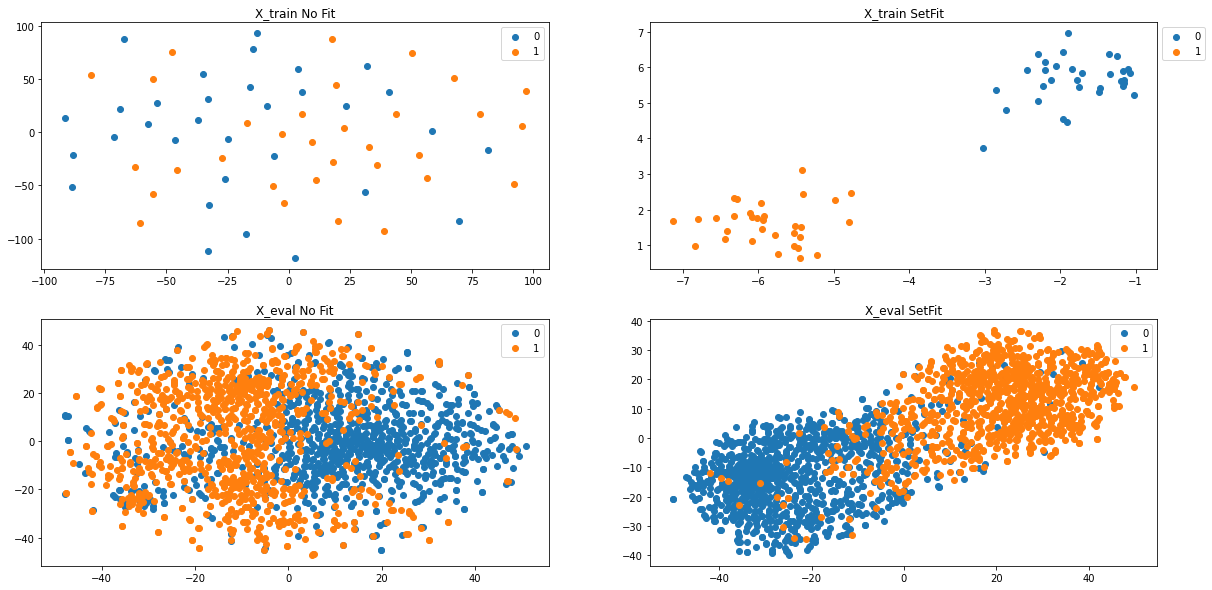

In [27]:
#Plot 2-D 2x2 figures
if plot2d_checkbox:   

  plt.figure(figsize=(20,10))

#Plot X_train_noFit
  X_embedded = TSNE(n_components=2).fit_transform(np.array(X_train_noFT))
  plt.subplot(221)
  plt.title('X_train No Fit')

  for i, t in enumerate(set(np.array(y_train))):
      idx = np.array(y_train) == t
      plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

  plt.legend(bbox_to_anchor=(1, 1));

#Plot X_eval noFit
  X_embedded = TSNE(n_components=2).fit_transform(np.array(X_eval_noFT))
  plt.subplot(223)
  plt.title('X_eval No Fit')

  for i, t in enumerate(set(np.array(y_eval))):
      idx = np.array(y_eval) == t
      plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

  plt.legend(bbox_to_anchor=(1, 1));


#Plot X_train SetFit
  X_embedded = TSNE(n_components=2).fit_transform(np.array(X_train))

  plt.subplot(222)
  plt.title('X_train SetFit')

  for i, t in enumerate(set(np.array(y_train))):
      idx = np.array(y_train) == t
      plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

  plt.legend(bbox_to_anchor=(1, 1));

#Plot X_eval SetFit
  X_embedded = TSNE(n_components=2).fit_transform(np.array(X_eval))
  plt.subplot(224)
  plt.title('X_eval SetFit')

  for i, t in enumerate(set(np.array(y_eval))):
      idx = np.array(y_eval) == t
      plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

  plt.legend(bbox_to_anchor=(1, 1));
